In [2]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path_csv = "../../../Thesis_data/processed_data/"
path_model = "../../../Thesis_data/Models/"

In [4]:
#https://mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas

def rm(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [12]:
X_test_unscaled = pd.read_csv(path_csv + "ontime_reporting_X_test_unscaled.csv")
X_test = pd.read_csv(path_csv + "ontime_reporting_X_test.csv")
y_test = pd.read_csv(path_csv + "ontime_reporting_y_test.csv")

X_test = rm(X_test)
y_test = np.ravel(y_test)

Memory usage of dataframe is 314.23 MB
Memory usage after optimization is: 78.56 MB
Decreased by 75.0%


In [3]:
#Load airline full names
airlines = pd.read_csv("../_1. Data Preprocessing/UNIQUE_CARRIERS.csv")
airlines

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.
...,...,...
1724,ZW,Air Wisconsin Airlines Corp
1725,ZX,Air Georgian
1726,ZX (1),Airbc Ltd.
1727,ZY,Atlantic Gulf Airlines


In [9]:
xgb_class_tuned_ros = joblib.load(path_model + "XGBoost_tuned_ROS.joblib")
y_pred_xgb_tuned_ros = xgb_class_tuned_ros.predict(X_test)
#y_pred_prob_xgb_tuned_ros = xgb_class_tuned_ros.predict_proba(X_test)[:, 1]

C:\Users\Rvanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:160: UserWarning: [15:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
C:\Users\Rvanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:160: UserWarning: [15:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


In [13]:
y_diff = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_xgb_tuned_ros})
y_diff['Difference'] = np.where(y_diff['y_test'] == y_diff['y_pred'], 0, 1) #0 means no difference, 1 means a difference
merged_df = X_test_unscaled.merge(y_diff, left_index=True, right_index=True)
merged_df = merged_df.merge(airlines, left_on="OP_UNIQUE_CARRIER", right_on="Code")

In [16]:
merged_df = merged_df.merge(airlines, left_on="OP_UNIQUE_CARRIER", right_on="Code")
merged_df

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,CRS_DEP_TIME,CRS_ARR_TIME,DISTANCE_GROUP,NUMBER_OF_SEATS,AWND,PRCP,...,ORIGIN_LONG,DEST_LAT,DEST_LONG,PREV_FLIGHT_DELAY,PLANE_AGE,y_test,y_pred,Difference,Code,Description
0,8,15,4,9E,501,630,5,76,6.49,0.32,...,-83.3533,29.9844,-95.3414,0,13,0,0,0,9E,Endeavor Air Inc.
1,8,17,6,9E,690,813,3,76,8.05,0.44,...,-81.8498,42.3643,-71.0052,0,5,1,1,0,9E,Endeavor Air Inc.
2,10,8,2,9E,1302,1404,2,76,8.50,0.01,...,-71.0052,42.9405,-78.7322,0,11,0,0,0,9E,Endeavor Air Inc.
3,6,13,4,9E,787,883,2,76,11.41,0.08,...,-84.6678,38.8522,-77.0378,0,11,1,0,1,9E,Endeavor Air Inc.
4,11,25,1,9E,1235,1352,3,76,8.95,0.00,...,-83.3533,40.6397,-73.7789,0,5,0,0,0,9E,Endeavor Air Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113144,12,4,3,EV,870,1096,5,70,8.28,0.00,...,-95.3414,41.4117,-81.8498,0,0,0,0,0,EV,ExpressJet Airlines LLC d/b/a aha!
1113145,11,20,3,EV,540,660,4,70,3.80,0.01,...,-84.6678,29.9844,-95.3414,0,0,0,0,0,EV,ExpressJet Airlines LLC d/b/a aha!
1113146,2,22,5,EV,610,745,3,50,7.61,0.00,...,-87.9047,36.1984,-95.8881,0,18,0,0,0,EV,ExpressJet Airlines LLC d/b/a aha!
1113147,5,25,6,EV,360,474,3,50,8.50,0.04,...,-84.2194,40.6925,-74.1686,0,15,1,1,0,EV,ExpressJet Airlines LLC d/b/a aha!


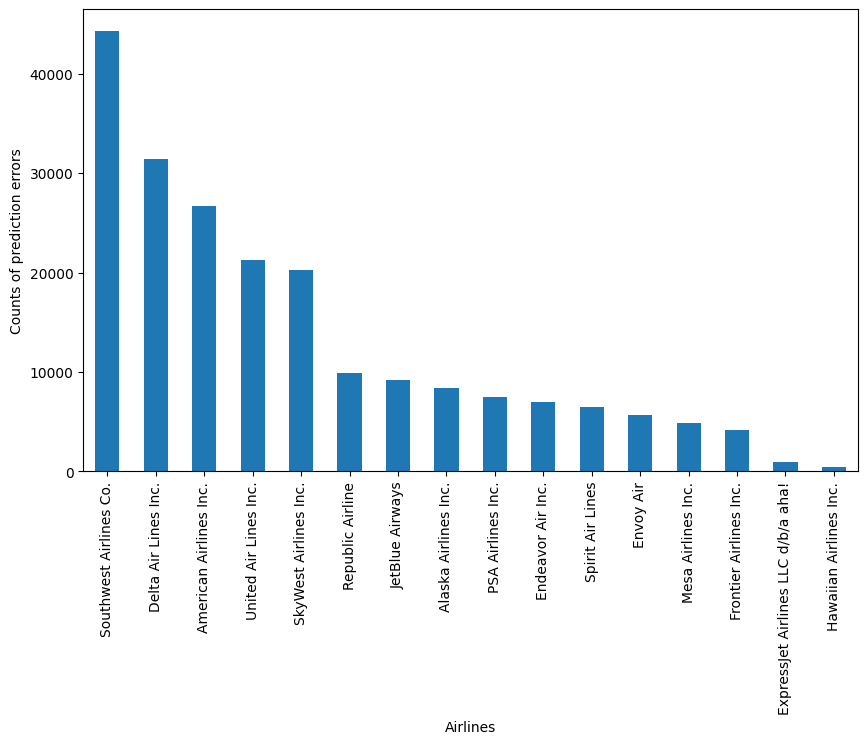

In [18]:
df_filtered = merged_df[merged_df["Difference"] == 1]

counts = df_filtered.groupby("Description")["Difference"].count()
counts = counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
counts.plot(kind="bar")
#plt.title("Count of 1s in binary_column per Airline")
plt.xlabel("Airlines")
plt.ylabel("Counts of prediction errors")
plt.xticks(rotation=90)
plt.show()

<Figure size 1000x600 with 0 Axes>

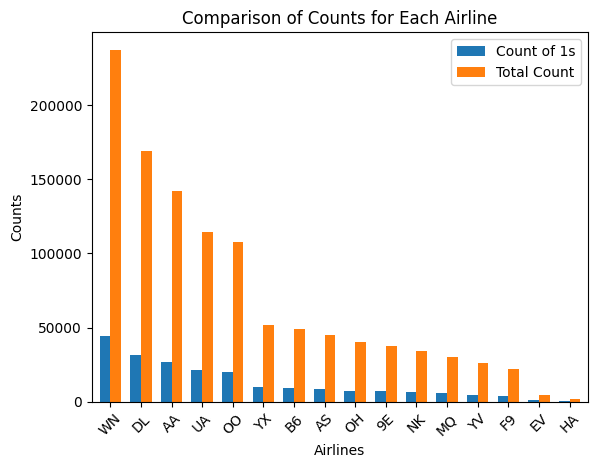

In [27]:
df_filtered = merged_df[merged_df["Difference"] == 1]

counts = df_filtered.groupby("OP_UNIQUE_CARRIER")["Difference"].count()
counts = counts.sort_values(ascending=False)

total_counts = merged_df.groupby("Description").size()

combined_counts = pd.concat([counts, total_counts], axis=1)
combined_counts.columns = ["Count of 1s", "Total Count"]

plt.figure(figsize=(10, 6))
combined_counts.plot(kind="bar", width=0.7)
plt.title("Comparison of Counts for Each Airline")
plt.xlabel("Airlines")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.show()

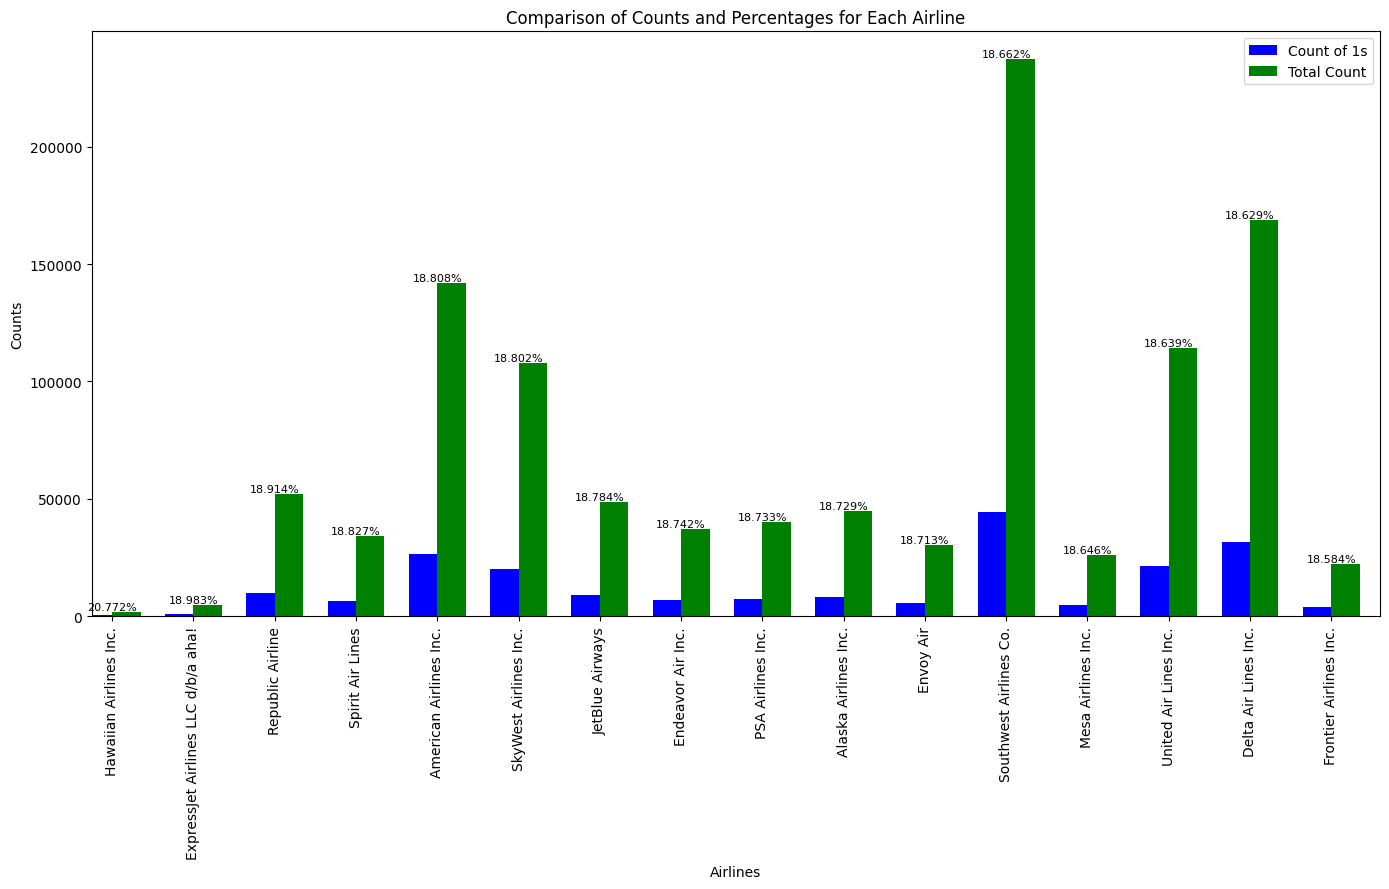

In [50]:
df_filtered = merged_df[merged_df["Difference"] == 1]

counts = df_filtered.groupby("Description")["Difference"].count()
counts = counts.sort_values(ascending=False)

total_counts = merged_df.groupby("Description").size()

combined_counts = pd.concat([counts, total_counts], axis=1)
combined_counts.columns = ["Count of 1s", "Total Count"]

def calculate_error_percentage(row):
    return round(((row['Count of 1s'] / row['Total Count']) * 100), 3)

combined_counts['error_percentage'] = combined_counts.apply(calculate_error_percentage, axis=1)

combined_counts = combined_counts.sort_values(by='error_percentage', ascending=False)

plt.figure(figsize=(14, 9))

combined_counts['Count of 1s'].plot(kind="bar", width=0.35, position=1, color='b', align='center', label='Count of 1s')
combined_counts['Total Count'].plot(kind="bar", width=0.35, position=0, color='g', align='center', label='Total Count')

for i, value in enumerate(combined_counts['error_percentage']):
    plt.text(i, max(combined_counts['Count of 1s'][i], combined_counts['Total Count'][i]) + 10, f"{value}%", ha='center', va='bottom', fontsize=8)

plt.title("Comparison of Counts and Percentages for Each Airline")
plt.xlabel("Airlines")
plt.ylabel("Counts")
plt.xticks(range(len(combined_counts.index)), combined_counts.index, rotation=90)
plt.legend()
plt.tight_layout()  # Adjust layout for better display
plt.show()